<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Gaussian elimination

## Contents

In this notebook, we will learn

- How to parallelize Gaussian elimination
- What is load imbalance, and how to fix it in this algorithm

<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to execute the cell below before starting this notebook! 
</div>

In [ ]:
using Printf
function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done!"
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
function ge_par_why()
    msg = "The outer loop of the algorithm is not parallelizable, since the iterations depend on the results of the previous iterations. However, we can extract parallelism from the inner loops."
    println(msg)
end
ge_par_check(answer) = answer_checker(answer, "a")
ge_dep_check(answer) = answer_checker(answer, "b")
function ge_lb_answer()
    msg = "It is a form of static load balancing. We know in advance the load distribution and the partition strategy does not depend on the actual values of the input matrix"
    println(msg)
end
println("🥳 Well done!")

## Gaussian elimination


[Gaussian elimination](https://en.wikipedia.org/wiki/Gaussian_elimination) is a method to solve systems of linear equations, like this one:

$$
\left[
\begin{matrix}
1 & 3 & 1 \\
1 & 2 & -1 \\
3 & 11 & 5 \\
\end{matrix}
\right]
\left[
\begin{matrix}
x \\
y \\
z  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
9 \\
1 \\
35  \\
\end{matrix}
\right].
$$

This is just a small example with three unknowns, but practical applications need to solve linear equations with large number of unknowns. Parallel processing is needed in these cases.

### Problem statement

Let us consider a system of linear equations written in matrix form $Ax=b$, where $A$ is a nonsingular square matrix, and $x$ and $b$ are vectors. $A$ and $b$ are given, and $x$ is unknown. The goal of Gaussian elimination is to transform the system $Ax=b$, into a new system $Ux=c$ such that
- both systems have the same solution vector $x$,
- the matrix $U$ of the new system is *upper triangular* with unit diagonal, namely $U_{ii} = 1$ and $U_{ij} = 0$ for $i>j$.


For the particular system shown above, the transformed one is the following:

$$
\left[
\begin{matrix}
1 & 3 & 1 \\
1 & 2 & -1 \\
3 & 11 & 5 \\
\end{matrix}
\right]
\left[
\begin{matrix}
x \\
y \\
z  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
9 \\
1 \\
35  \\
\end{matrix}
\right]
\longrightarrow
\left[
\begin{matrix}
1 & 3 & 1 \\
0 & 1 & 2 \\
0 & 0 & 1 \\
\end{matrix}
\right]
\left[
\begin{matrix}
x \\
y \\
z  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
9 \\
8 \\
4  \\
\end{matrix}
\right]
$$

The most challenging part of solving a system of linear equations is to transform it to upper triangular form. Afterwards, the solution vector can be obtained easily with a backward substitution. For this reason, we will study here the triangulation step only.



### Augmented system matrix

In practice, vector $b$ is added as an additional column to A forming the so-called *augmented* matrix $A^* = [A  b]$. The augmented matrix in the example above is

$$
\left[
\begin{matrix}
1 & 3 & 1 \\
1 & 2 & -1 \\
3 & 11 & 5 \\
\end{matrix}
\right]
\left[
\begin{matrix}
x \\
y \\
z  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
9 \\
1 \\
35  \\
\end{matrix}
\right]\longrightarrow
A^*=
\left[
\begin{matrix}
1 & 3 & 1 & 9  \\
1 & 2 & -1 & 1 \\
3 & 11 & 5 & 35\\
\end{matrix}
\right].
$$

With this new notation, the goal of Gaussian elimination is to find the augmented matrix containing $U$ and $c$, namely $U^*= [U  c]$, given the augmented matrix $A^* = [A  b]$. These are $A^*$ and $U^*$ in our example:

$$
A^*=
\left[
\begin{matrix}
1 & 3 & 1 & 9  \\
1 & 2 & -1 & 1 \\
3 & 11 & 5 & 35\\
\end{matrix}
\right]\longrightarrow
U^*=
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & 1 & 2 & 8\\
0 & 0 & 1 & 4\\
\end{matrix}
\right].
$$



### Serial implementation


The following algorithm computes the Gaussian elimination on a given augmented matrix `B`, representing a system of linear equations. The result is given by overwriting `B`, avoiding the allocation of an additional matrix.

- The outer loop is a loop over rows.
- The first inner loop in line 4 divides the current row by the value of the diagonal entry, thus transforming the diagonal to contain only ones. Note that we skip the first entries in the row, as we know that these values are zero at this point. The cells updated in this loop at iteration $k$ are depicted in red in the figure below.
- The second inner loop beginning in line 8 subtracts the rows from one another such that all entries below the diagonal become zero. The entries updated in this loop are depicted in blue in the figure below.

In [ ]:
function gaussian_elimination!(B)
    n,m = size(B)
    @inbounds for k in 1:n
        for t in (k+1):m
            B[k,t] =  B[k,t]/B[k,k]
        end
        B[k,k] = 1
        for i in (k+1):n 
            for j in (k+1):m
                B[i,j] = B[i,j] - B[i,k]*B[k,j]
            end
            B[i,k] = 0
        end
    end
    B
end

<div>
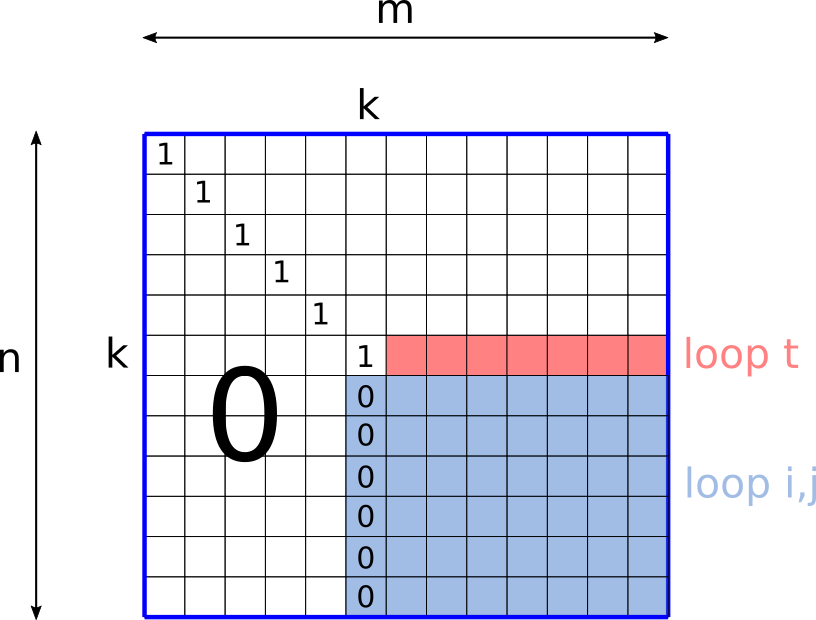
</div>
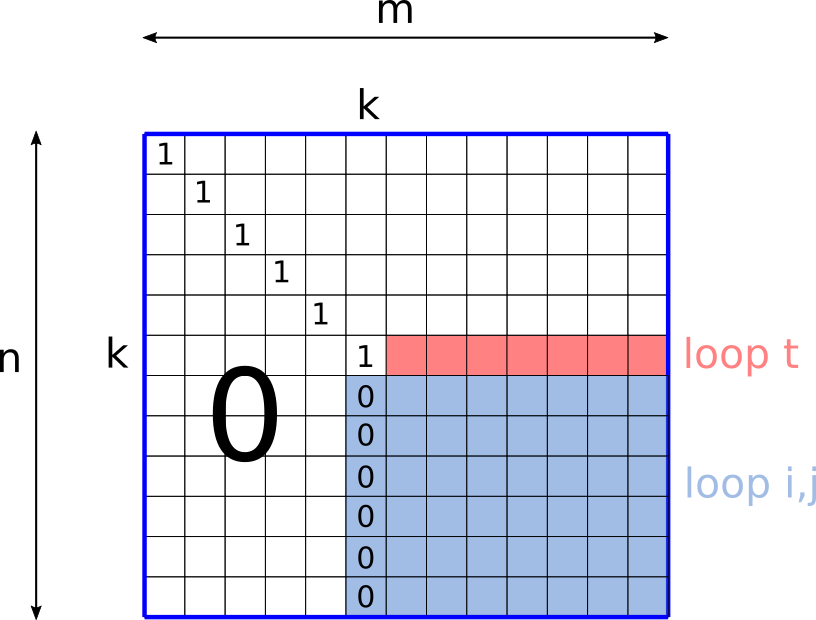

<div class="alert alert-block alert-info">
<b>Note:</b> This algorithm is not correct for all nonsingular matrices: if any diagonal element <code>B[k,k]</code> is zero, the computation in the first inner loop fails. To get around this problem, another step can be added to the algorithm that swaps the rows until the diagonal entry of the current row is not zero. This process of finding a nonzero value is called <b>pivoting</b>. We are not going to consider pivoting here for simplicity.  
</div>

You can verify that the algorithm computes the upper triangular matrix correctly for the example in the introduction by running the following code cell. 

In [ ]:
A = Float64[1 3 1; 1 2 -1; 3 11 5]
b = Float64[9,1,35]
B = [A b]
gaussian_elimination!(B)

### Complexity of the algorithm

The number of operations of the algorithm is $O(N^3)$, where $N$ is the number of unknowns in the system. Intuitively, this makes sense as there are three nested loops. However, the length of the loops is not equal to $N$. In any case, it can be proven that the total number of operations is still $O(N^3)$. The actual proof is a bit challenging and it is not discussed here.

## Parallelization


### Where can we extract parallelism?

```julia
n,m = size(B)
for k in 1:n
    for t in (k+1):m
        B[k,t] =  B[k,t]/B[k,k]
    end
    B[k,k] = 1
    for i in (k+1):n 
        for j in (k+1):m
            B[i,j] = B[i,j] - B[i,k]*B[k,j]
        end
        B[i,k] = 0
    end
end
```

<div class="alert alert-block alert-success">
<b>Question:</b>  Which of the loops can be parallelized?
</div>

    a) the inner loops, but not the outer loop
    b) the outer loop, but not the inner loops
    c) all loops
    d) only the first inner loop

In [ ]:
answer = "x" # replace x with a, b, c, or d 
ge_par_check(answer)

In [ ]:
ge_par_why()

### Data partition

Let's start considering a row-wise block partition, as we did in previous algorithms.

In the figure below, we use different colors to illustrate which entries are assigned to a CPU. All entries with the same color are assigned to the same CPU.

<div>
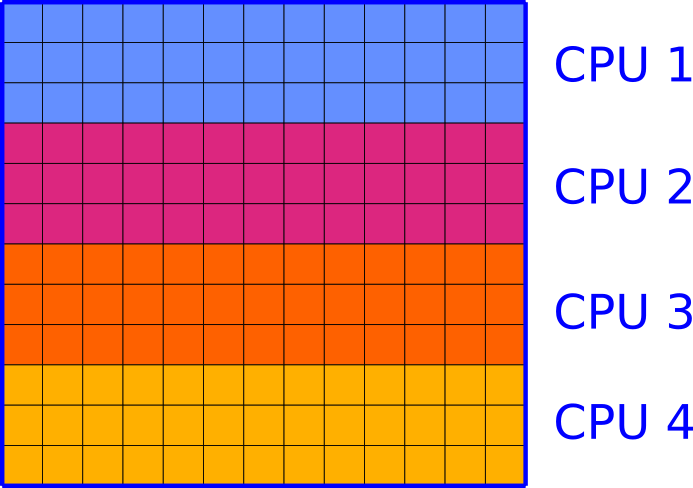
</div>
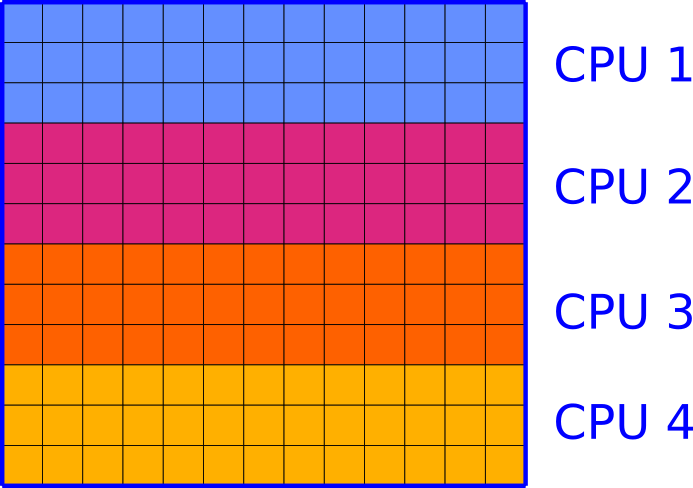

### Load imbalance

Each CPU will be on charge of updating the entries stored locally. However, this algorithm is a bit different than the previous ones. At iteration $k$ only a subset of the entries in the matrix `B` are updated, i.e. only the entries in the bottom right block  `B[k:end,k:end]` are updated. This block is illustrated in a darker color in the next figure for $k=6$. 

<div>
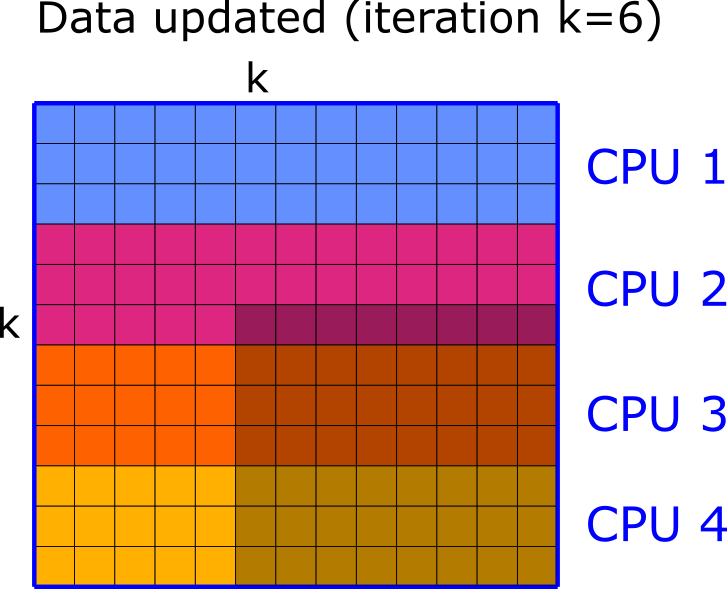
</div>
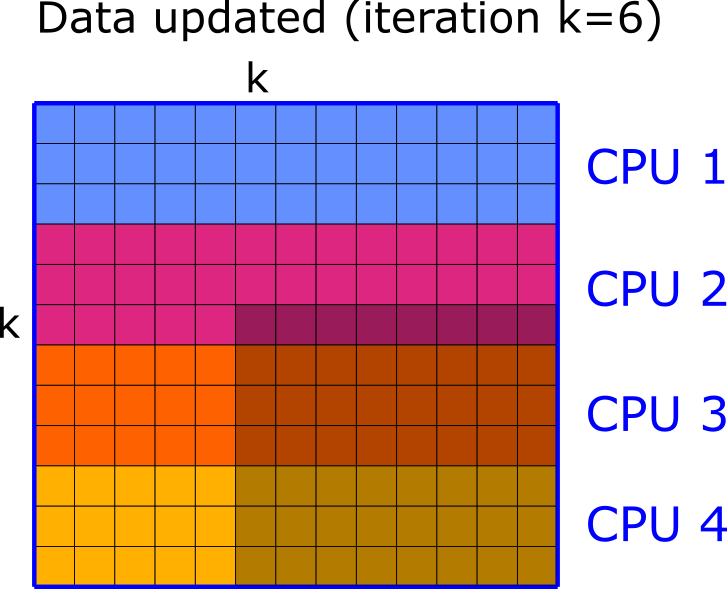

In this particular example CPU 1 will not have any work to do at iteration $k=6$ and it will be waiting, while other CPUs are computing. In general, CPUs containing rows previous to row $k$ will have less work to do than CPUs containing rows after row $k$. This will worsen as the value of $k$ increases. At some point, only the last CPU will have work to do and the others will idle. 

<div class="alert alert-block alert-info">
<b>Definition:</b> *Load imbalance*: is the problem when work is not equally distributed over all processes and consequently some processes do more work than others.
</div>

Having processors waiting for others is a waste of computational resources and affects negatively parallel speedups. The optimal speedup (speedup equal to the number of processors) assumes that the work is perfectly parallel and that it is evenly distributed. If there is load imbalance, the last assumption is not true anymore and the speedup will be suboptimal.


### Fixing load imbalance

In this application, is relatively easy to fix the load imbalance problem. We know in advance which data is going to be processes at each CPU and we can design a more clever data partition.

We can consider row-wise cyclic partition to fix the problem. See figure below. In this case, the CPUs will have less work as the value of $k$ increases, but amount of work will be better distributed than with the previous row block partition.

<div>
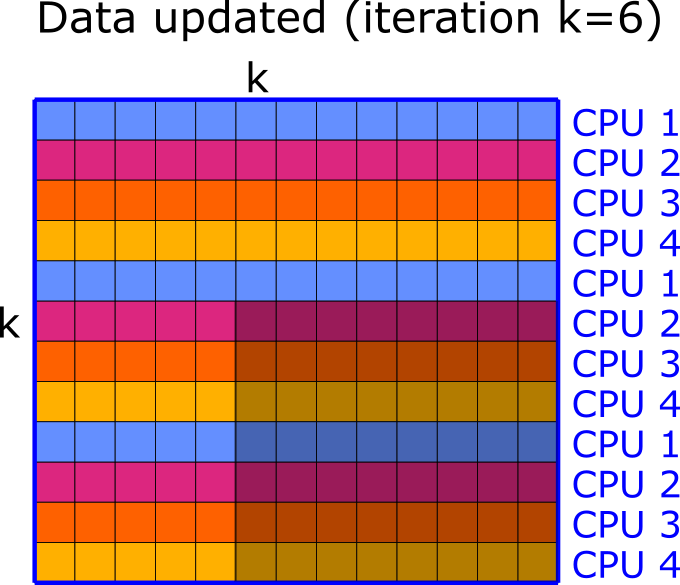
</div>
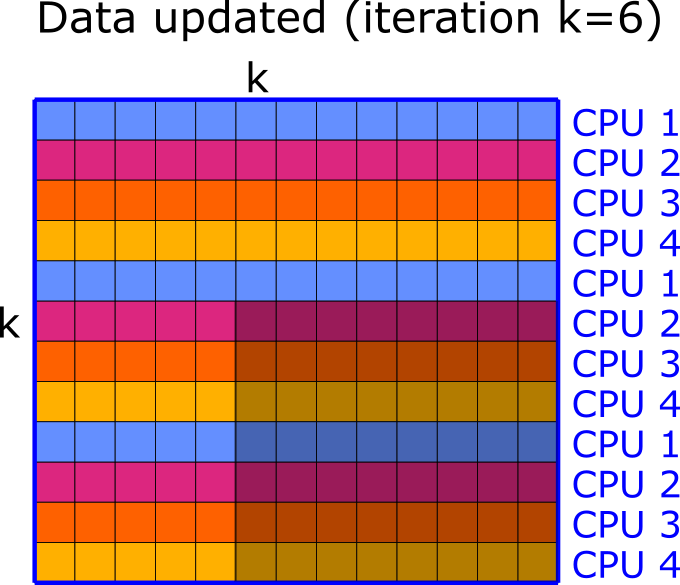

### Static vs dynamic load balancing

Load balancing is the process of distributing work to processors uniformly with the aim to efficiently exploit a parallel system. There are two key forms of load balancing: Static and dynamic load balancing.

- **Static load balancing**  the work distribution strategy is based on prior information of the algorithm and it does not depend on runtime values.
- **Dynamic load balancing** the work distribution strategy is based on runtime values.

Static load balancing is often used in algorithms for which the load distribution is known in advance and it does not depend on runtime values. On the other hand, dynamic load balancing is often needed in problems in which the work distribution cannot be predicted in advance and depends on runtime values.



<div class="alert alert-block alert-success">
<b>Question:</b>  Using a cyclic partition for Gaussian elimination, is a form of static or dynamic load balancing?
</div>



In [ ]:
ge_lb_answer()

### Data dependencies

Using a cyclic partition, we managed to distribute the work uniformly. But we still need to study the data dependencies in order to implement this algorithm in parallel efficiently.

Look again to the algorithm

```julia
n,m = size(B)
for k in 1:n
    for t in (k+1):m
        B[k,t] =  B[k,t]/B[k,k]
    end
    B[k,k] = 1
    for i in (k+1):n 
        for j in (k+1):m
            B[i,j] = B[i,j] - B[i,k]*B[k,j]
        end
        B[i,k] = 0
    end
end
```

Note that all updates on the loop over i and j we do the following: 

```julia
B[i,j] = B[i,j] - B[i,k]*B[k,j]
```

As we are using row-wise partitions, the CPU that updates `B[i,j]` will also have entry `B[i,k]` in memory (both are in the same row). However, `B[k,j]` is in another row and it might be located on another processor. We might need to communicate `B[k,j]` for `j=(k+1):m`. This corresponds to the cells marked in red in the figure below.  These red entries are the data dependencies of this algorithm. The owner of these entries has to send them to the other processors. This is very similar to the communication pattern seen in previous notebook for Floyd's algorithm. There is a key difference however. In the current case, we do not need to send the full row, only the entries beyond column $k$ (the red cells in the figure).


<div>
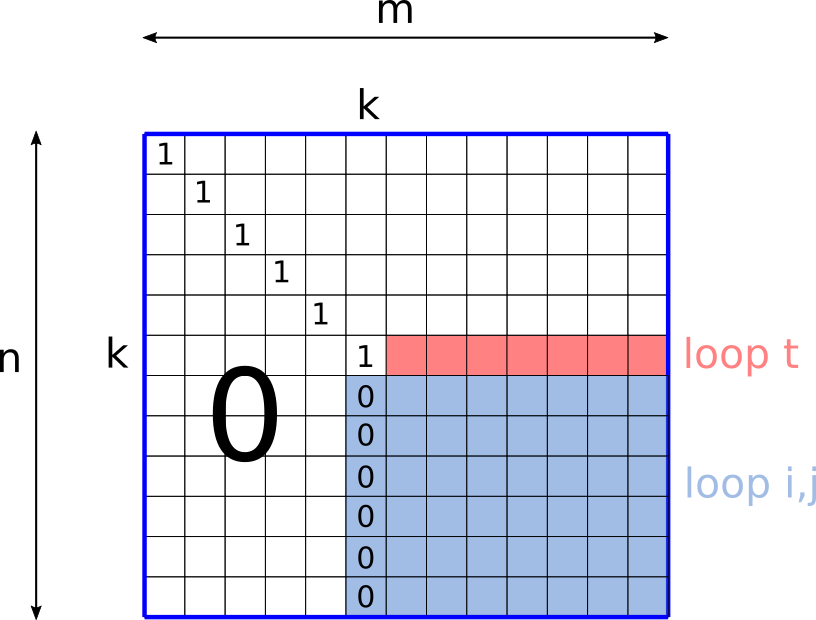
</div>
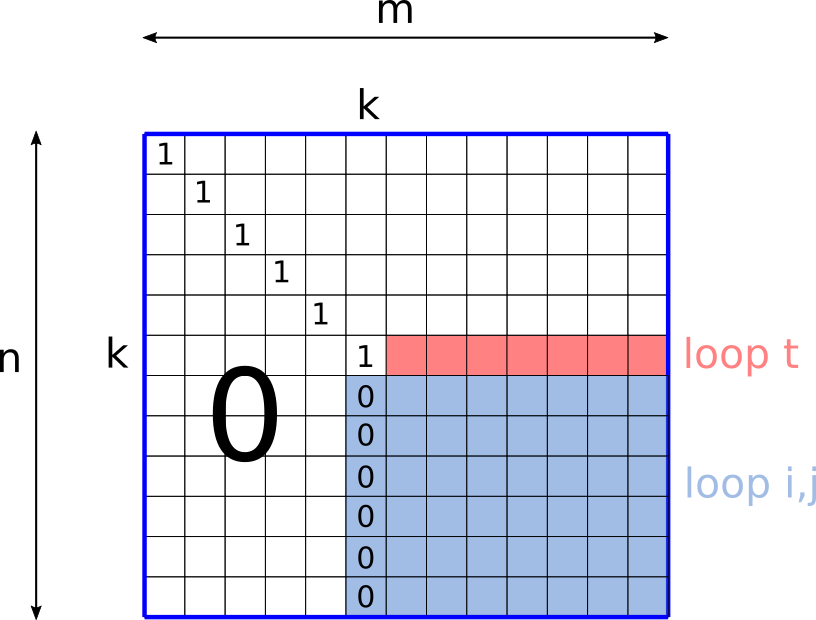

### Parallel implementation


At iteration $k$,

1. The CPU owning row $k$ does the loop over $t$ to update row $k$.
2. The CPU owning row $k$ sets $B_{kk} = 1$.
2. This CPU sends the red cells in figure above to the other processors.
3. All processors receive the updated values in row $k$ and do the loop over i and j locally (blue cells).


As you probably see, the parallel implementation of this method is closely related to Floyd's algorithm. But there are some differences. 

1. The process that owns row $k$ updates its values before sending them.
2. We do not send the full row $k$, only the entries beyond column $k$.
3. We need a cyclic partition to balance the load properly.

A key similarity between the two algorithms, however, is that they both suffer from synchronization problems. We need to make sure that the rows arrive in the right order. The strategies discussed for Floyd's algorithm also apply in this current case.

The actual implementation of the parallel algorithm is left as an open exercise.

## Conclusion


We studied the parallelization of an algorithm that leads to load imbalance. We fixed the problem using a cyclic partition. This is a form of static load balancing since we were able to distribute the load in advance without using runtime values. This is opposed to dynamic load balancing which can schedule loads flexibly during runtime. Note however that cyclic partitioning is not suitable for all communication patterns. For example, it can lead to a large communication overhead in the parallel Jacobi method, since the computation of each value depends on its neighboring elements.


# License



This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.